In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynumdiff

2025-06-13 11:55:01,978 [INFO] Import Error.
Could not import cvxpy.
To use convex total variation regularized derivatives, install cvxpy (http://www.cvxpy.org/install/index.html)
 Recommended solver: MOSEK, free academic license available: https://www.mosek.com/products/academic-licenses/
Despite this error, you can still use the iterative TVR method.

2025-06-13 11:55:01,991 [INFO] Import Error
Could not import cvxpy.
Install cvxpy (http://www.cvxpy.org/install/index.html) to use lineardiff.
Recommended solver: MOSEK, free academic license available: https://www.mosek.com/products/academic-licenses/ 

2025-06-13 11:55:01,992 [INFO] Import Error
Despite these import errors, you can still use many of the methods without additional installations.



# Load data
This data-frame has the raw ros-topic data for most of the sensors on the Matrice plus the transformed data that matches the drone model.
I will illustrate how to interpret the accelerometer data in the context of our model.

In [2]:
# Change this path to the .csv location
data_path = 'matrice_data_processed.csv'
data = pd.read_csv(data_path)
data

,time,gps_x,gps_y,gps_z,rtk_position_x,rtk_position_y,rtk_position_z,rtk_velocity_x,rtk_velocity_y,rtk_velocity_z,...,sensor_r_x,sensor_r_y,sensor_r,z,sensor_r_x_cal,sensor_r_y_cal,sensor_r_cal,sensor_beta,sensor_beta_dot,v_z_dot
0,0.0,39.549055,-119.869786,1495.235604,3.718348e-07,0.000030,-0.173339,-7.325736,-2.548049,-0.025040,...,7.765428,0.606573,7.789082,78.006047,9.885317,0.772162,9.915428,0.077954,-0.006998,0.117148
1,0.1,39.549052,-119.869795,1495.242466,-1.927907e-06,0.000021,-0.170754,-7.407878,-2.559387,-0.024289,...,7.712115,0.591956,7.734800,78.012909,9.818313,0.753621,9.847193,0.076606,-0.008209,-0.140207
2,0.2,39.549050,-119.869804,1495.248708,-4.206720e-06,0.000013,-0.168335,-7.500800,-2.563812,-0.022257,...,7.658909,0.577134,7.680623,78.019152,9.751357,0.734810,9.779003,0.075212,-0.009421,0.098842
3,0.3,39.549048,-119.869813,1495.255138,-6.430387e-06,0.000004,-0.168504,-7.581062,-2.514952,-0.004910,...,7.605884,0.562110,7.626627,78.025582,9.684643,0.715740,9.711055,0.073771,-0.010599,0.073958
4,0.4,39.549045,-119.869821,1495.261338,-8.615319e-06,-0.000005,-0.168946,-7.643779,-2.467805,0.010653,...,7.553111,0.546889,7.572884,78.031782,9.618211,0.696414,9.643391,0.072280,-0.011743,-0.057098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,88.9,39.549070,-119.870090,1518.295162,1.988317e-05,-0.000282,24.490398,-2.955255,-4.024079,-0.056958,...,3.244912,-0.545266,3.290406,101.065605,5.351841,-0.899308,5.426874,-0.166482,-0.001072,-0.138774
890,89.0,39.549067,-119.870094,1518.297279,1.656466e-05,-0.000286,24.485407,-3.124255,-3.928706,-0.093825,...,3.245088,-0.545175,3.290564,101.067722,5.352244,-0.899176,5.427249,-0.166446,-0.001430,-0.113570
891,89.1,39.549064,-119.870098,1518.296990,1.345106e-05,-0.000291,24.481121,-3.316537,-3.765349,-0.054112,...,3.245233,-0.545097,3.290694,101.067434,5.352467,-0.899047,5.427447,-0.166415,-0.001802,-0.241347
892,89.2,39.549061,-119.870103,1518.294172,1.054081e-05,-0.000295,24.478881,-3.505133,-3.563966,-0.014718,...,3.245349,-0.545033,3.290798,101.064616,5.352510,-0.898916,5.427468,-0.166390,-0.002188,0.156796


# Visualize trajectory
This trajectory starts out by turning without changing heading, and ends by turning with heading changes.

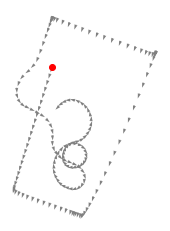

In [3]:
time = data['time'].values
dt = np.mean(np.diff(time))
x = data['x'].values
y = data['y'].values
psi = data['psi'].values

# For plotting arrows only
dx = np.cos(psi)
dy = np.sin(psi)

skip = 5
plt.quiver(x[::skip], y[::skip], dx[::skip], dy[::skip], color='gray', scale=30, width=0.01)
plt.plot(x[0], y[0], color='red', marker='o')
plt.gca().set_aspect(1.0)
plt.gca().set_axis_off()

The heading & velocity (in body-level frame) is consistent with the trajectory.

Note: I can use these velocities (or positions) + heading to perfectly reconstruct the trajectory via MPC, so I know these are correct (they come from GPS).

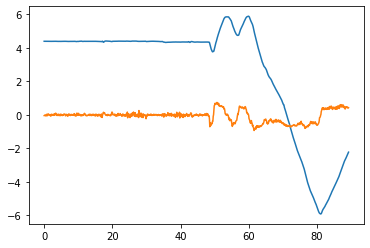

In [4]:
# Heading + angular velocity
psi_dot = data['psi_dot'].values
# psi_dot = pynumdiff.smooth_finite_difference.gaussiandiff(psi, dt, [10])[1]
plt.plot(time, psi)
plt.plot(time, psi_dot)

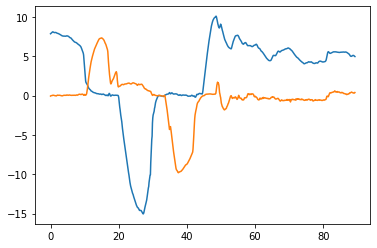

In [5]:
# Velocities in body-level frame (comes from transforming GPS velocity in global frame into body-level frame)
v_x = data['v_x'].values
v_y = data['v_y'].values
plt.plot(time, v_x)
plt.plot(time, v_y)

# Acceleration paradox
Now let's look at the acceleration in the body-level frame & compare it to the accelerometer data.

If we simply take the derivative of the body-level frame velocities, we can see that they match the kinematics of the trajectory

For instance, in the turning part of the trajectory both x & y accelerations are near 0.

In [9]:
v_x_dot = pynumdiff.smooth_finite_difference.gaussiandiff(v_x, dt, [10],options={'iterate': False})[1]
v_y_dot = pynumdiff.smooth_finite_difference.gaussiandiff(v_y, dt, [10],options={'iterate': False})[1]

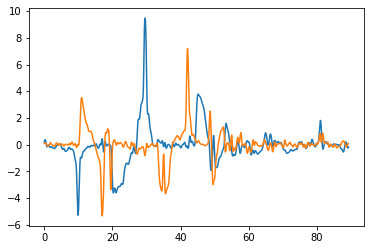

In [10]:
plt.plot(time, v_x_dot)
plt.plot(time, v_y_dot)

# Global frame accelerations

In [12]:
v_x_global_dot = pynumdiff.smooth_finite_difference.gaussiandiff(data['rtk_velocity_x'].values, dt, [10],options={'iterate': False})[1]
v_y_global_dot = pynumdiff.smooth_finite_difference.gaussiandiff(data['rtk_velocity_y'].values, dt, [10],options={'iterate': False})[1]

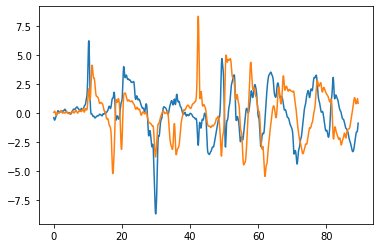

In [13]:
plt.plot(time, v_x_global_dot)
plt.plot(time, v_y_global_dot)

### Compare global frame accelerations to matrice provided data

Note: x and y seem to be swapped.

In [14]:
# Acceleration in global frame directly from matrice
v_x_dot_global = data['v_x_dot_global'].values
v_y_dot_global = data['v_y_dot_global'].values
v_z_dot_global = data['v_z_dot_global'].values

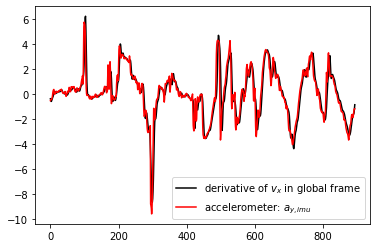

In [15]:
plt.plot(v_x_global_dot, color='black', label='derivative of $v_x$ in global frame')
plt.plot(v_y_dot_global, color='red', label='accelerometer: $a_{y,imu}$')
plt.legend()

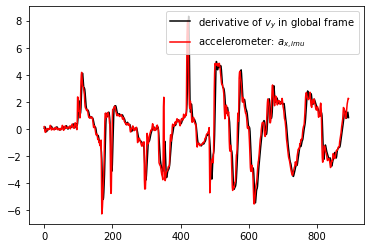

In [16]:
plt.plot(v_y_global_dot, color='black', label='derivative of $v_y$ in global frame')
plt.plot(v_x_dot_global, color='red', label='accelerometer: $a_{x,imu}$')
plt.legend()

# Project global frame accelerations back into body frame

In [17]:
v_x_global_dot_in_bodyframe = np.cos(psi)*v_x_global_dot - np.sin(psi)*v_y_global_dot
v_y_global_dot_in_bodyframe = np.sin(psi)*v_x_global_dot + np.cos(psi)*v_y_global_dot

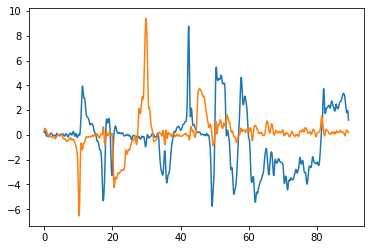

In [18]:
plt.plot(time, v_x_global_dot_in_bodyframe)
plt.plot(time, v_y_global_dot_in_bodyframe)

### compare body frame accelerations

In [19]:
# Use rotation matrix used to derive drone dynamics
a_x_dot_from_imu = v_x_dot_global*np.cos(psi) + v_y_dot_global*np.sin(psi)
a_y_dot_from_imu = -v_x_dot_global*np.sin(psi) + v_y_dot_global*np.cos(psi)

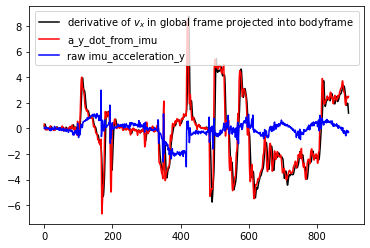

In [20]:
plt.plot(v_x_global_dot_in_bodyframe, color='black', label='derivative of $v_x$ in global frame projected into bodyframe')
plt.plot(a_y_dot_from_imu, color='red', label='a_y_dot_from_imu')
plt.plot(data['imu_acceleration_y'].values, color='blue', label='raw imu_acceleration_y')
plt.legend()

In [21]:
# calculate the coriolis terms
coriolis_x = data['v_y'].values*psi_dot
coriolis_y = -data['v_x'].values*psi_dot

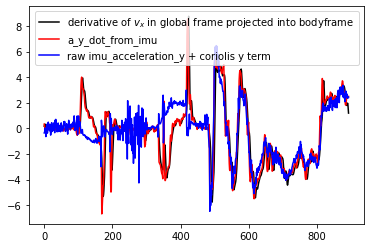

In [22]:
plt.plot(v_x_global_dot_in_bodyframe, color='black', label='derivative of $v_x$ in global frame projected into bodyframe')
plt.plot(a_y_dot_from_imu, color='red', label='a_y_dot_from_imu')
plt.plot( -(data['imu_acceleration_y'].values + coriolis_y), color='blue', label='raw imu_acceleration_y + coriolis y term')
plt.legend()

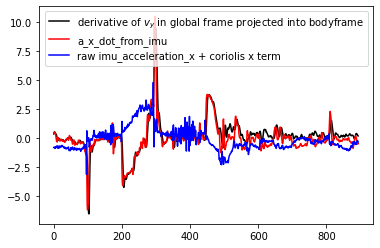

In [23]:
plt.plot(v_y_global_dot_in_bodyframe, color='black', label='derivative of $v_y$ in global frame projected into bodyframe')
plt.plot(a_x_dot_from_imu, color='red', label='a_x_dot_from_imu')
plt.plot( (data['imu_acceleration_x'].values + coriolis_x), color='blue', label='raw imu_acceleration_x + coriolis x term')
plt.legend()